# 🩺 CNN Cancer Detection Using Histopathologic Images

## 📕 [Link to Project Notebook](#) <!-- Update with actual link -->

This project aims to perform binary image classification to identify metastatic cancer in small image patches taken from larger digital pathology scans. The objective is to assist pathologists in diagnosing cancer more accurately and efficiently by leveraging Convolutional Neural Networks (CNNs).

## 📊 Dataset
We use the Histopathologic Cancer Detection dataset, which includes image patches extracted from pathology scans. The dataset is publicly available on Kaggle. [Link to the Histopathologic Cancer Detection Dataset on Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

## ✅ Table of Contents
1. [Introduction](#introduction)
2. [Problem Analysis](#problem-analysis)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [About the Data and Initial Data Cleaning](#about-the-data-and-initial-data-cleaning)
    - [Data Distribution Analysis](#data-distribution-analysis)
    - [Correlations Analysis](#correlations-analysis)
    - [Outlier Analysis](#outlier-analysis)
    - [Final Data Cleaning](#final-data-cleaning-and-outlier-removal)
4. [Model Training and Evaluation](#model-training-and-evaluation)
    - [Model Training](#model-training)
    - [Evaluation](#evaluation)
5. [Results and Discussion](#results-and-discussion)
    - [Clustering Results](#clustering-results)
    - [Visualization and Interpretation](#visualization-and-interpretation)
    - [Discussion](#discussion)
6. [Conclusion](#conclusion)
7. [References](#references)

## Introduction
In this project, we aim to perform binary image classification using Convolutional Neural Networks (CNNs) to identify metastatic cancer in histopathologic images. The dataset used is derived from the PatchCamelyon (PCam) benchmark dataset, providing a straightforward yet clinically relevant task.

## Problem Analysis
### What is the Problem and Its Impact on Industry?
The problem we are addressing is detecting metastatic cancer in histopathologic images. Accurate and efficient detection of cancerous tissues is crucial for timely diagnosis and treatment, significantly impacting patient outcomes.

### Machine Learning Model and Rationale
For this project, we will use Convolutional Neural Networks (CNNs), which are highly effective in image classification tasks. CNNs can automatically learn and extract features from images, making them suitable for identifying patterns in medical images.

### Expected Outcome
The expected outcome is to develop a CNN model that can accurately classify image patches as either cancerous or non-cancerous. This model will assist pathologists in diagnosing cancer, enhancing the accuracy and efficiency of cancer detection.



## Exploratory Data Analysis (EDA) 📊

### 1. Load the Data

We begin by loading the necessary libraries and the dataset. The labels for the training images are loaded from the `_labels.csv` file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Load the labels
labels_df = pd.read_csv('train/_labels.csv')
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### 2. Data Cleaning

We check for any missing values in the labels dataframe and handle them if necessary. Fortunately, there are no missing values in our dataset.

In [2]:
# Check for missing values and drop it
print(labels_df.isnull().sum())
labels_df.dropna(inplace=True)

id       0
label    0
dtype: int64


### 3. Data Distribution Analysis

Next, we visualize the distribution of the labels to understand the balance of the dataset. The dataset contains a higher number of non-cancerous images compared to cancerous ones.

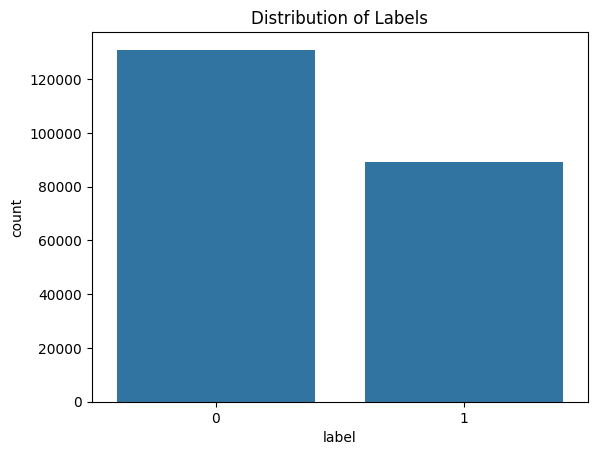

In [3]:
# distribution of labels
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels')
plt.show()

### 4. Sample Images

We load and display a few sample images from the dataset to get an idea of what the data looks like. Below are sample images for both classes (0: non-cancerous, 1: cancerous).

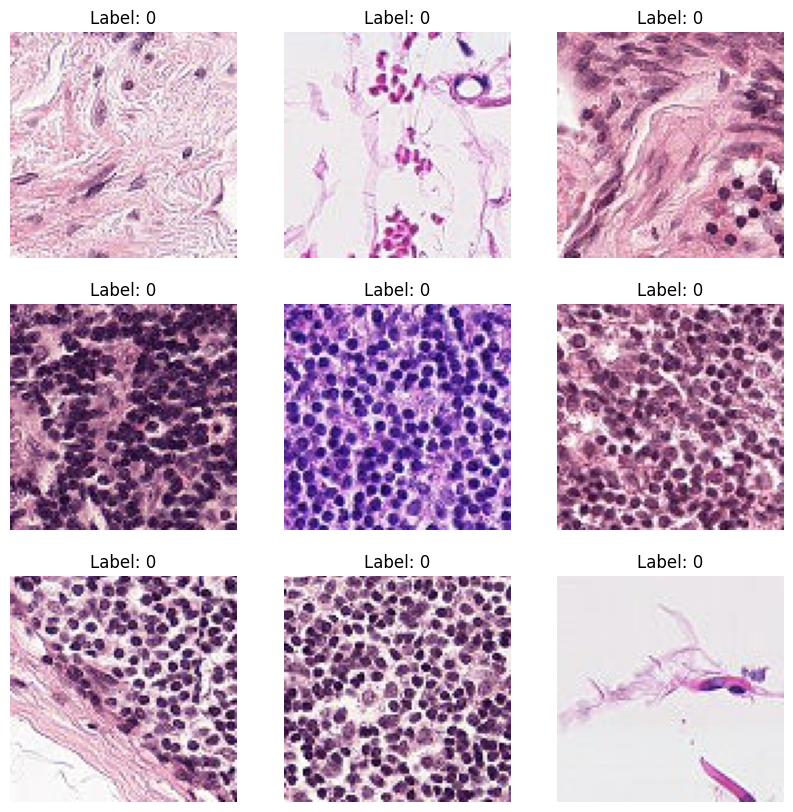

In [4]:
# Function to load and display sample images
def display_sample_images(image_ids, label):
    plt.figure(figsize=(10, 10))
    for i, image_id in enumerate(image_ids):
        image_path = f'train/{image_id}.tif'
        image = Image.open(image_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()
    
# Display sample images with label 0
sample_image_ids_0 = labels_df[labels_df['label'] == 0].sample(9)['id'].values
display_sample_images(sample_image_ids_0, label=0)

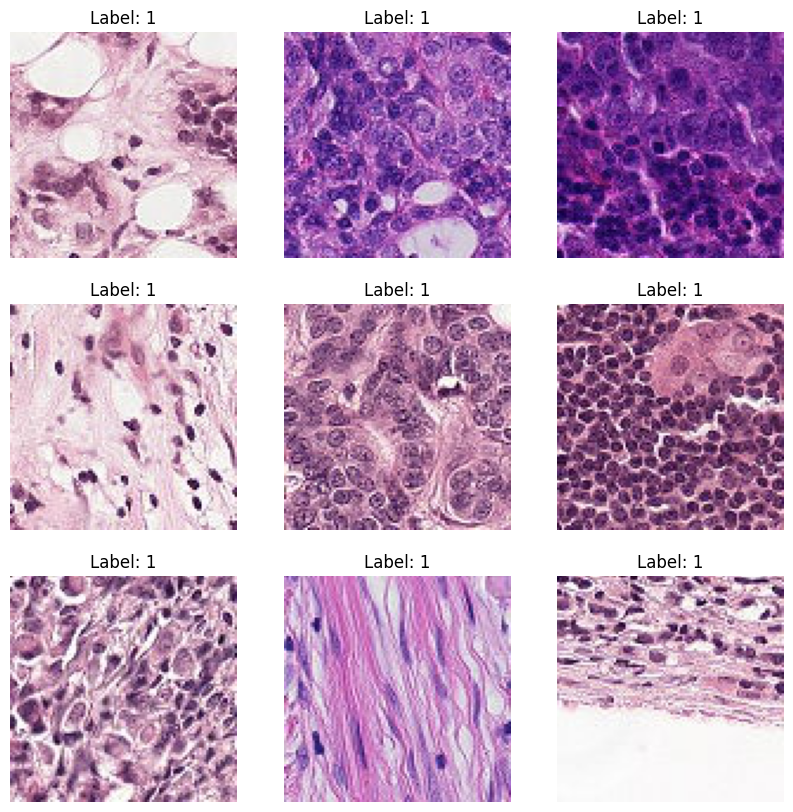

In [5]:
# Display sample images with label 1
sample_image_ids_1 = labels_df[labels_df['label'] == 1].sample(9)['id'].values
display_sample_images(sample_image_ids_1, label=1)

### 5. Data Cleaning Procedures

We ensure that all images are of the same size (96x96 pixels) and RGB format. This step confirms the consistency of the image data.

In [6]:
# Check the size and mode of a few sample images
def check_image_properties(image_ids):
    for image_id in image_ids:
        image_path = f'train/{image_id}.tif'
        image = Image.open(image_path)
        print(f'Image ID: {image_id}, Size: {image.size}, Mode: {image.mode}')

# We check a few properties of a few sample images
sample_image_ids = labels_df['id'].sample(5).values
check_image_properties(sample_image_ids)

Image ID: d6eed214851222add9f9cb14f87889b819070c1a, Size: (96, 96), Mode: RGB
Image ID: 189a8feb62975a6932f3f32368e017bda16c9910, Size: (96, 96), Mode: RGB
Image ID: 81778f7095afed9201c73fdabb8644d5f8f580f9, Size: (96, 96), Mode: RGB
Image ID: 3334656054bcd6c1229dab2af214cc4177b16c13, Size: (96, 96), Mode: RGB
Image ID: b9e83d4c54c26fc49fc96e71b5891fad4b48ad91, Size: (96, 96), Mode: RGB


# Model Training and Evaluation 🧠

## Model Architecture

In this step, we design and train a Convolutional Neural Network (CNN) to identify metastatic cancer in histopathologic images. The CNN is chosen due to its ability to learn spatial hierarchies of features, making it highly effective for image classification tasks, particularly in medical imaging.

Here is the detailed breakdown of our model architecture:

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

# Load the labels
labels_df = pd.read_csv('train/_labels.csv')

# Change data types to string
labels_df['id'] = labels_df['id'] + '.tif'
labels_df['label'] = labels_df['label'].astype(str)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(labels_df, test_size=0.2, random_state=42)

Now we will configure data generators for training and validation using TensorFlow's `ImageDataGenerator`. It first sets up the training data generator with various augmentations like rescaling, rotation, shifting, shearing, and flipping to enhance the model's robustness. Then, it creates a validation data generator with only rescaling. The `flow_from_dataframe` method is used to generate batches of augmented/normalized data from the provided dataframes (`train_df` and `valid_df`), specifying the image directory, target size, batch size, and class mode. This setup helps efficiently manage and preprocess the large dataset during model training.

In [5]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Now let's start by importing the necessary layers from TensorFlow's Keras module. These layers include convolutional, pooling, and normalization layers, which are essential for building our CNN. We initialize a Sequential model, which is a linear stack of layers.

- **Conv2D Layer**: The first layer is a convolutional layer with 32 filters, each of size 3x3. This layer is responsible for extracting features from the input images. We use the ReLU activation function to introduce non-linearity.
- **MaxPooling2D Layer**: This layer reduces the spatial dimensions (height and width) of the feature maps by a factor of 2, which helps in reducing the computational cost and the risk of overfitting.
- **BatchNormalization Layer**: Batch normalization is applied to stabilize and accelerate the training process.

The second set of convolutional, pooling, and normalization layers follows the same pattern but increases the number of filters to 64, allowing the model to learn more complex features.

The third set of layers further increases the number of filters to 128, enabling the model to capture even more detailed features.

- **Flatten Layer**: This layer flattens the 3D feature maps to 1D feature vectors, preparing the data for the dense layers.
- **Dense Layer**: A dense (fully connected) layer with 512 units and ReLU activation is added to learn from the features extracted by the convolutional layers.
- **Dropout Layer**: Dropout is applied with a rate of 0.5 to prevent overfitting by randomly setting half of the input units to zero during training.
- **Output Layer**: The final dense layer with a single unit and sigmoid activation function is used to produce the binary classification output (cancerous or non-cancerous).

We compile the model using the Adam optimizer, which adjusts the learning rate during training. The loss function used is binary cross-entropy, suitable for binary classification tasks, and we track the model’s accuracy.

In [6]:
# Define the model
model = Sequential()

# We initialize a Sequential model, which is a linear stack of layers.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# The second set of convolutional, pooling, and normalization layers follows the same pattern but increases the number of filters to 64, allowing the model to learn more complex features.
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# The third set of layers further increases the number of filters to 128, enabling the model to capture even more detailed features.
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 47, 47, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                        

## Training 
Next, we train the model using the training data and validate its performance on the validation set.


In [7]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=10
)

# Save the model
model.save('cancer_detection_model.h5')

Epoch 1/10
5501/5501 [==============================] - 384s 70ms/step - loss: 0.5560 - accuracy: 0.8137 - val_loss: 1.3045 - val_accuracy: 0.7041
Epoch 2/10
5501/5501 [==============================] - 397s 72ms/step - loss: 0.3550 - accuracy: 0.8512 - val_loss: 0.5667 - val_accuracy: 0.7555
Epoch 3/10
5501/5501 [==============================] - 401s 73ms/step - loss: 0.3140 - accuracy: 0.8731 - val_loss: 0.8688 - val_accuracy: 0.7410
Epoch 4/10
5501/5501 [==============================] - 386s 70ms/step - loss: 0.2898 - accuracy: 0.8853 - val_loss: 0.4182 - val_accuracy: 0.8348
Epoch 5/10
5501/5501 [==============================] - 395s 72ms/step - loss: 0.2724 - accuracy: 0.8935 - val_loss: 0.4620 - val_accuracy: 0.8205
Epoch 6/10
5501/5501 [==============================] - 389s 71ms/step - loss: 0.2625 - accuracy: 0.8978 - val_loss: 0.6899 - val_accuracy: 0.8105
Epoch 7/10
5501/5501 [==============================] - 391s 71ms/step - loss: 0.2538 - accuracy: 0.9024 - val_loss: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We use the `ImageDataGenerator` to handle image loading and augmentation on-the-fly, which helps in efficiently managing memory and enhancing the robustness of the model by augmenting the images during training.

- **steps_per_epoch**: This parameter defines the total number of steps (batches of samples) to draw from the generator before declaring one epoch finished and starting the next epoch.
- **validation_data**: The validation data is used to evaluate the model’s performance after each epoch.
- **epochs**: We train the model for 10 epochs, balancing between training time and performance improvement.

Finally, we save the trained model for future use. This step ensures that we can reuse the trained model for predictions without retraining.

## References
Veeling, B. S., Linmans, J., Winkens, J., Cohen, T., & Welling, M. (2018). Rotation Equivariant CNNs for Digital Pathology. arXiv:1806.03962.  
Ehteshami Bejnordi, B., et al. (2017). Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA, 318(22), 2199–2210. doi:10.1001/jama.2017.14585  
Kaggle. (n.d.). Histopathologic Cancer Detection. Retrieved from [https://www.kaggle.com/competitions/histopathologic-cancer-detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection).